- Un modelo de mezcla gaussiana (GMM) es un modelo probabilístico que da por supuesto que las instancias se han generado de una mezcla de varias distribuciones gaussianas cuyos parámetros de desconocen.

- Todas las instancias generadas a partir de una sola distribución gaussiana forman un grupo que suele ser un elipsoide.

- Cada grupo puede tener diferentes formas elipsoidales, tamaños, densidades y orientaciones.

- Cuando observas una instancia sabes que se ha generado a partir de una de las distribuciones gaussianas, pero se te dice cuál y no sabes cuáles son los parámetros de estas distribuciones.

- El objeto GaussianMixture implementa el algoritmo de maximización de expectativas (EM) para ajustar modelos de mezcla de gaussianos.

- GaussianMixture.fit proporciona un método que aprende un modelo de mezcla gaussiano a partir de los datos de entrenamiento. Dado los datos de prueba, puede asignar a cada muestra el gaussiano que probablemente pertenezca utilizando GaussianMixture.predict

- Pros:
    - Velocidad: es el algoritmo más rápido para aprender modelos de mezcla.
    - Agnóstico: como este algoritmo maximiza solo la probabilidad, no sesgará las medias hacia cero ni sesgará los tamaños de los conglomerados para tener estructuras específicas que podrían o no aplicarse.
- Cons:
    - Singularidades: cuando uno no tiene suficiente puntos por mezcla, la estimación de las matrices de covarianza se vuelve difícil y se sabe que el algoritmo diverge y encuentra soluciones con probabilidad infinita a menos que se regularicen las covarianzas artificialmente
    - Número de componentes: este algoritmo siempre usará todos los componentes a los que tiene acceso.

## Detección de anomalías utilizando mezclas gaussianas

- Es la tarea de detectar instancias que se desvían mucho de la norma.
    - Los valores normales se denominan inliers
    - Los valores no normales se denominan outliers
- Detección de novedades
    - se diferencia de la detección de anomalías en que se supone que el algoritmo se entrena con un conjunto de datos limpio, sin valores atípicos, mientras que la detección de anomalías no hace esa suposición.

## Modelos bayesianos de mezcla gaussiana

- La clase BayesianGaussianMixture es capaz de dar pesos iguales (o cercanos) a cero a grupos innecesarios.

- Establece el número de grupos `n_components` como un valor mayor que el número óptimo de grupos y el algoritmo eliminará los grupos innecesarios de forma automática.

In [25]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [26]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [27]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10)

In [28]:
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10)

In [29]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

- El algoritmo ha detectado de manera automática que solo se necesitan tres grupos.
- En este modelo, los parámetros de los gurpos ya no se tratan como params de modelos fijos, sino como variables aleatorias latentes, como las asignaciones de grupos. Así, ahora z incluye tanto los params como las asignaciones de los grupos.

In [30]:
from matplotlib.colors import LogNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

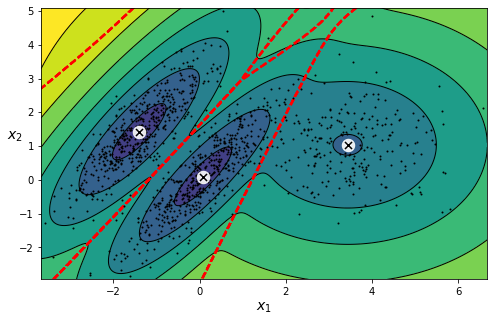

In [31]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()